In [1]:
import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading data

In [2]:
# Industry ticker list
supply_symbols = ['FDX', 'UPS', 'XPO', 'AMKBY', 'CSX']
insurance_symbols = ['PGR', 'TRV', 'RLI', 'ERIE', 'CB']
automotive_symbols = ['GM', 'TM', 'VOW3.DE', 'F', 'RACE', 'TSLA']
misc_symbols = ['CL=F', 'LKQ', 'MGA', 'NXPI', 'IFX.DE', 'MGA', 'KMX']
# Fetch the data
supply_data = yf.download(supply_symbols,period="10y")['Adj Close']
insurance_data = yf.download(insurance_symbols,period="10y")['Adj Close']
automotive_data = yf.download(automotive_symbols,period="10y")['Adj Close']
misc_data = yf.download(misc_symbols,period="10y")['Adj Close']
# print(returns_automotive)

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed


## Calculate returns

In [3]:
def calculate_ret(data):
    #Calculate Return
    returns = 100 * data.pct_change()
    returns.dropna(inplace = True)
    #Calculate average return
    returns['avg_return'] = returns.mean(axis=1)
    return returns

returns_supply = calculate_ret(supply_data)
returns_insurance = calculate_ret(insurance_data)
returns_automotive = calculate_ret(automotive_data)
returns_misc = calculate_ret(misc_data)
# print(returns_automotive)

## Plotting returns

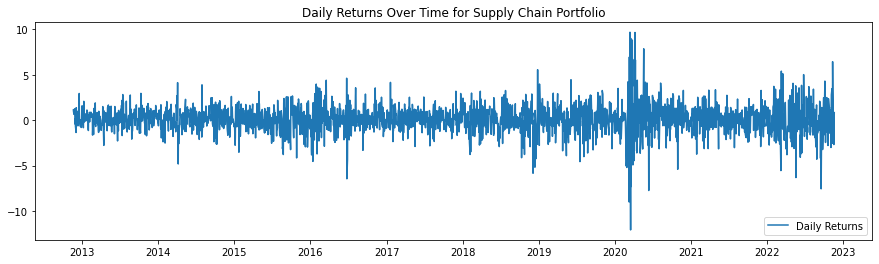

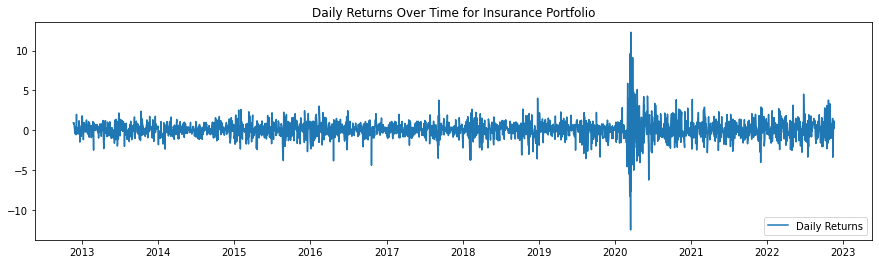

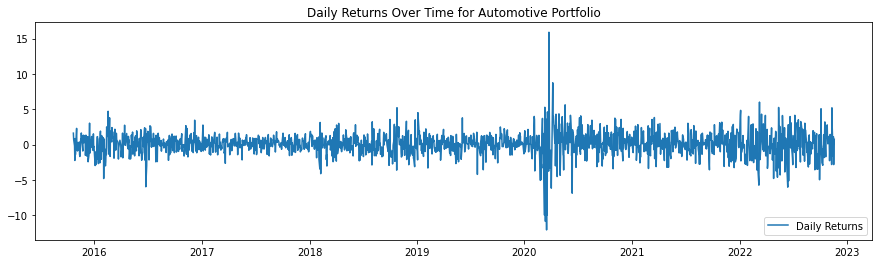

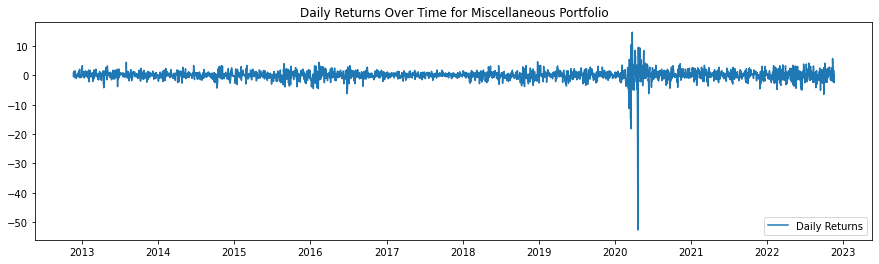

In [4]:
def plot_ret(data, pltitle):
    fig = plt.figure()
    fig.set_figwidth(15)
    plt.plot(data, label = 'Daily Returns')
    plt.legend(loc='lower right')
    plt.title(pltitle)
    plt.show()
    
plot_ret(returns_supply['avg_return'],'Daily Returns Over Time for Supply Chain Portfolio')
plot_ret(returns_insurance['avg_return'],'Daily Returns Over Time for Insurance Portfolio')
plot_ret(returns_automotive['avg_return'],'Daily Returns Over Time for Automotive Portfolio')
plot_ret(returns_misc['avg_return'],'Daily Returns Over Time for Miscellaneous Portfolio')

## Caluclating Daily, Monthly and Annual Volatility

In [5]:
def calculate_volatility(data,title):
    print('\n'+title+'\n')
    # weights = np.array([20, 20, 20, 20, 20]) / 100
    daily_volatility = data['avg_return'].std()
    # cov_supply = returns_supply.cov()
    # daily_volatility = np.round_(np.sqrt(np.dot(weights.T, np.dot(cov_supply, weights))), decimals = 4)
    print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

    monthly_volatility = math.sqrt(21) * daily_volatility
    # cov_supply = returns_supply.cov() * 21
    # monthly_volatility = np.round_(np.sqrt(np.dot(weights.T, np.dot(cov_supply, weights))), decimals = 4)
    print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

    annual_volatility = math.sqrt(251) * daily_volatility
    # cov_supply = returns_supply.cov() * 251
    # annual_volatility = np.round_(np.sqrt(np.dot(weights.T, np.dot(cov_supply, weights))), decimals = 4)
    print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

calculate_volatility(returns_supply,'Supply Chain Portfolio')
calculate_volatility(returns_insurance,'Insurance Portfolio')
calculate_volatility(returns_automotive,'Automotive Portfolio')
calculate_volatility(returns_misc,'Miscellaneous Portfolio')


Supply Chain Portfolio

Daily volatility:  1.56%
Monthly volatility:  7.13%
Annual volatility:  24.65%

Insurance Portfolio

Daily volatility:  1.18%
Monthly volatility:  5.42%
Annual volatility:  18.74%

Automotive Portfolio

Daily volatility:  1.65%
Monthly volatility:  7.55%
Annual volatility:  26.11%

Miscellaneous Portfolio

Daily volatility:  1.93%
Monthly volatility:  8.85%
Annual volatility:  30.58%


## Volatility forecasting using GARCH  model

In [6]:
#6-period ahead Volatility forecast using GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Model
# p: The number of lag variances to include in the GARCH model
# q: The number of lag residual errors to include in the GARCH model
def garch_vol_forecast(data,days, title):
    #creating model instance
    garch_model = arch_model(data, p = 1, q = 1,mean = 'constant', vol = 'GARCH', dist = 'normal')
    #fitting the model
    gm_result = garch_model.fit(disp='off')
    print('\nGARCH model parameters for '+title+'\n')
    print(gm_result.params)
    # print('\n GARCH model summary for '+title+'\n')
    # print(gm_result.summary)

    print('\n'+str(days)+'-period ahead Volatility forecast\n')
    #forcasting volatility for desired number of days
    gm_forecast = gm_result.forecast(horizon = days)
    print(gm_forecast.variance[-1:])
    
garch_vol_forecast(returns_supply['avg_return'],7,'Supply Chain Portfolio')
garch_vol_forecast(returns_insurance['avg_return'],7,'Insurance Portfolio')
garch_vol_forecast(returns_automotive['avg_return'],7,'Automotive Portfolio')
garch_vol_forecast(returns_misc['avg_return'],7,'Miscellaneous Portfolio')


GARCH model parameters for Supply Chain Portfolio

mu          0.103923
omega       0.062833
alpha[1]    0.088319
beta[1]     0.883322
Name: params, dtype: float64

7-period ahead Volatility forecast

                 h.1       h.2       h.3       h.4       h.5       h.6  \
Date                                                                     
2022-11-18  4.781791  4.709018  4.638308  4.569604  4.502848  4.437985   

                 h.7  
Date                  
2022-11-18  4.374961  

GARCH model parameters for Insurance Portfolio

mu          0.079433
omega       0.042674
alpha[1]    0.110449
beta[1]     0.852922
Name: params, dtype: float64

7-period ahead Volatility forecast

                 h.1       h.2       h.3       h.4       h.5       h.6  \
Date                                                                     
2022-11-18  1.504283  1.491857  1.479885  1.468352  1.457241  1.446538   

                 h.7  
Date                  
2022-11-18  1.436226  

GARCH model pa

#### The impact of the stock's immediate volatility is directly proportional to the size of the subsequent alpha value. On the other side, a higher beta suggests that the volatility impact would last longer.

## Rolling Prediction using GARCH model

In [7]:
def garch_model(data,tr_days_size,horizon_size = 1, monthly=False):
    rolling_pred = []
    rolling_pred_index = []    
    test_trading_days = tr_days_size
    for i in range(0,tr_days_size,horizon_size):
        #creating train data
        train_data = data[:-(test_trading_days-i)]
        #creating model instance
        g_model = arch_model(train_data, p=1, q=1)
        #fitting the model
        g_fit = g_model.fit(disp='off')
        #forecasting for next day
        pred = g_fit.forecast(horizon=horizon_size)      
        if monthly:
            loop_size=horizon_size
        else:
            loop_size=1
        for j in range(0,horizon_size,loop_size):
            #appending the forecasting volatility to list            
            #print(np.sqrt(pred.variance.values[-1,:][j]))
            rolling_pred.append(np.sqrt(pred.variance.values[-1,:][j]))
            rolling_pred_index.append(data.index[len(train_data)+horizon_size-1])
        
    rolling_pred = pd.Series(rolling_pred, index=rolling_pred_index)
    return rolling_pred

def plot_pred(rolling_pred, pltitle):
    plt.figure(figsize=(15,5))
    plt.plot(rolling_pred)
    plt.title(pltitle)
    plt.show()

In [8]:
tr_days_size = 750
sc_rolling_predictions = garch_model(returns_supply['avg_return'],tr_days_size)
i_rolling_predictions  = garch_model(returns_insurance['avg_return'],tr_days_size)
a_rolling_predictions  = garch_model(returns_automotive['avg_return'],tr_days_size)
m_rolling_predictions  = garch_model(returns_misc['avg_return'],tr_days_size)

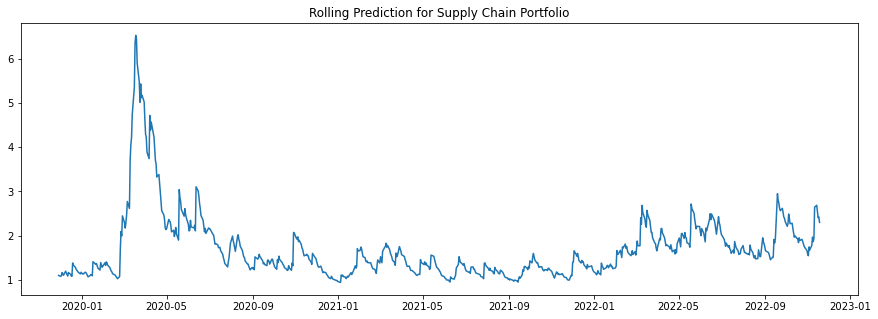

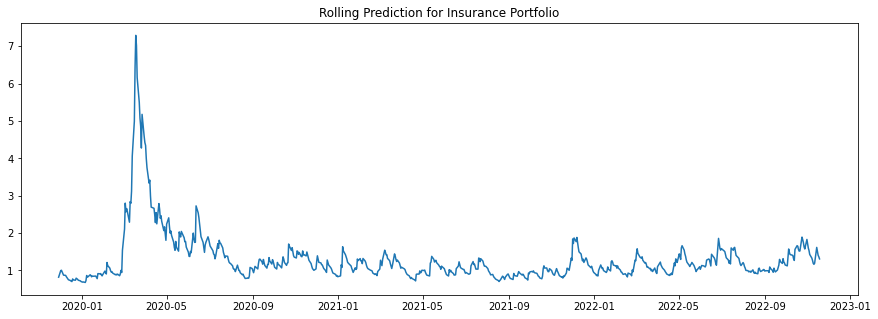

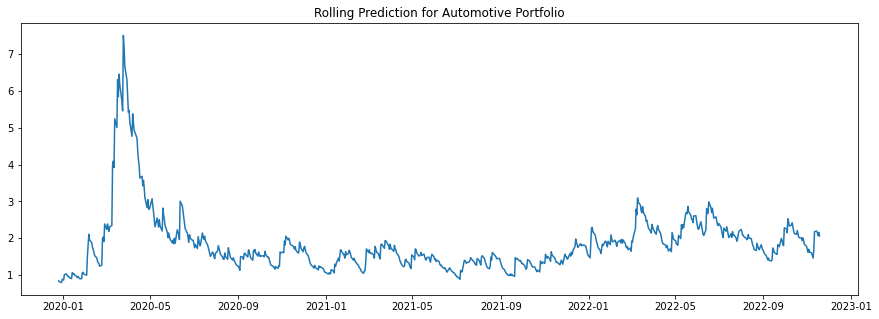

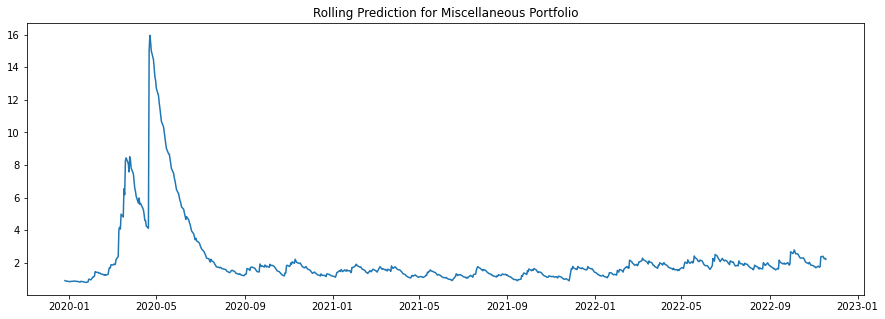

In [9]:
#Plotting the rolling predictions
plot_pred(sc_rolling_predictions,'Rolling Prediction for Supply Chain Portfolio')
plot_pred(i_rolling_predictions,'Rolling Prediction for Insurance Portfolio')
plot_pred(a_rolling_predictions,'Rolling Prediction for Automotive Portfolio')
plot_pred(m_rolling_predictions,'Rolling Prediction for Miscellaneous Portfolio')

## Checking accuracy of GARCH Model

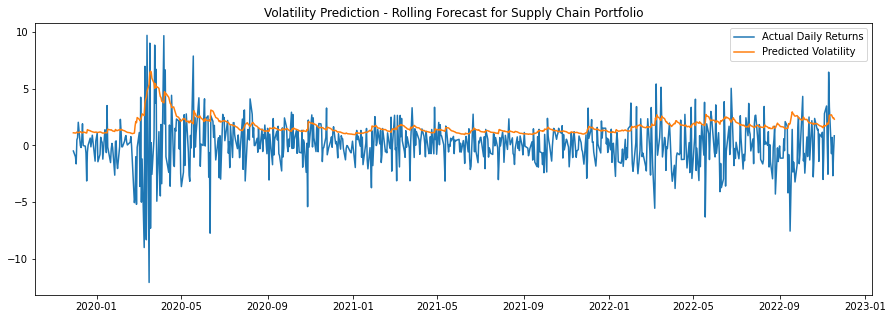

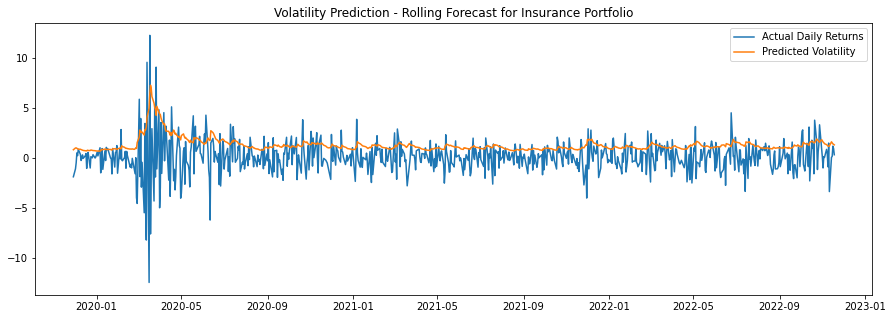

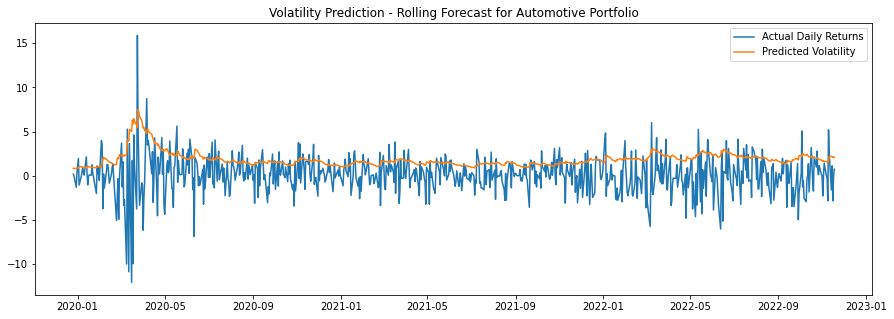

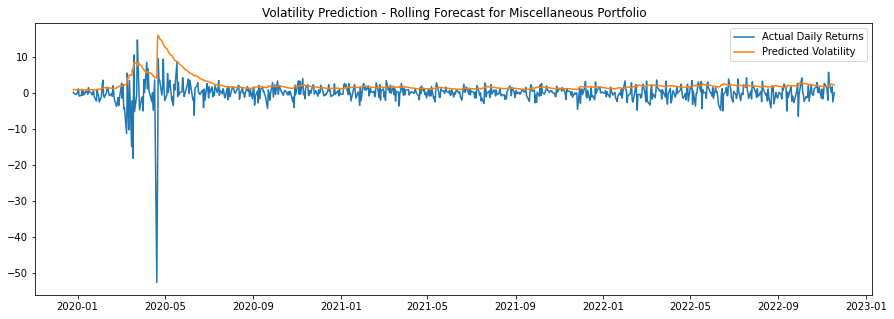

In [10]:
def plot_act_pred(actual_data,rolling_pred, pltitle):
    plt.figure(figsize=(15,5))
    plt.plot(actual_data[-tr_days_size:])
    plt.plot(rolling_pred)
    plt.title(pltitle)
    plt.legend(['Actual Daily Returns', 'Predicted Volatility'])
    plt.show()

plot_act_pred(returns_supply['avg_return'],sc_rolling_predictions,'Volatility Prediction - Rolling Forecast for Supply Chain Portfolio')
plot_act_pred(returns_insurance['avg_return'],i_rolling_predictions,'Volatility Prediction - Rolling Forecast for Insurance Portfolio')
plot_act_pred(returns_automotive['avg_return'],a_rolling_predictions,'Volatility Prediction - Rolling Forecast for Automotive Portfolio')
plot_act_pred(returns_misc['avg_return'],m_rolling_predictions,'Volatility Prediction - Rolling Forecast for Miscellaneous Portfolio')

## Rolling Prediction for 30 days at a time

In [11]:
tr_days_size = 750
#rolling Prediction of 30 days at a time
horizon_size = 30
sc_30_rolling_predictions = garch_model(returns_supply['avg_return'],tr_days_size,horizon_size)
i_30_rolling_predictions  = garch_model(returns_insurance['avg_return'],tr_days_size,horizon_size)
a_30_rolling_predictions  = garch_model(returns_automotive['avg_return'],tr_days_size,horizon_size)
m_30_rolling_predictions  = garch_model(returns_misc['avg_return'],tr_days_size,horizon_size)

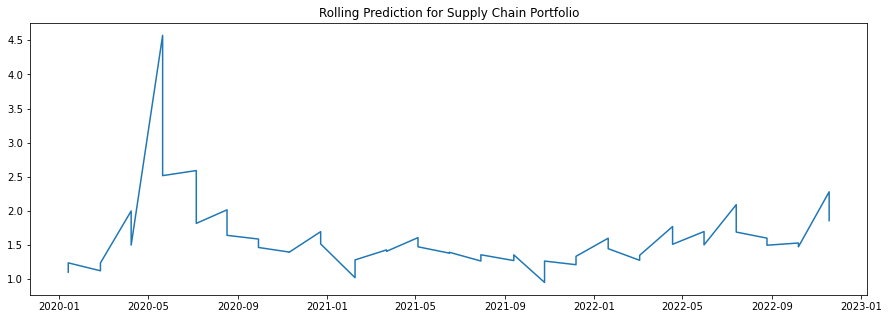

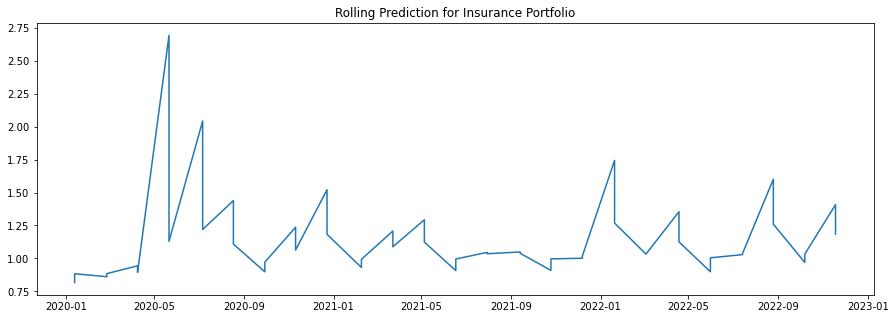

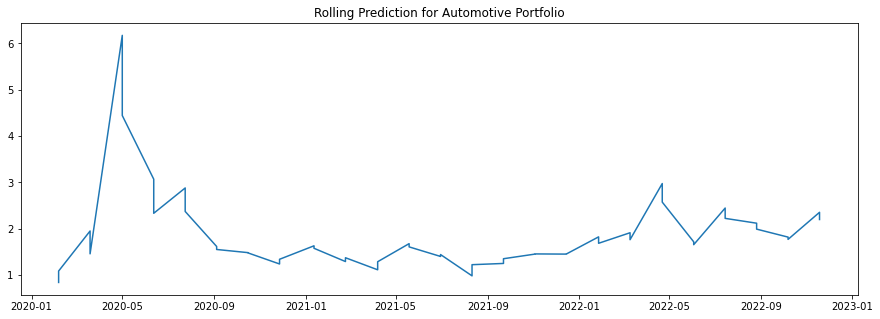

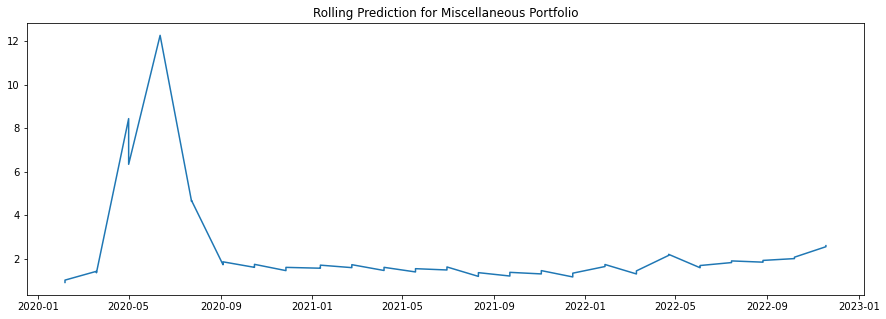

In [12]:
#Plotting the rolling predictions
plot_pred(sc_30_rolling_predictions,'Rolling Prediction for Supply Chain Portfolio')
plot_pred(i_30_rolling_predictions,'Rolling Prediction for Insurance Portfolio')
plot_pred(a_30_rolling_predictions,'Rolling Prediction for Automotive Portfolio')
plot_pred(m_30_rolling_predictions,'Rolling Prediction for Miscellaneous Portfolio')

## Checking accuracy of GARCH Model for 30 days of Prediction at a time

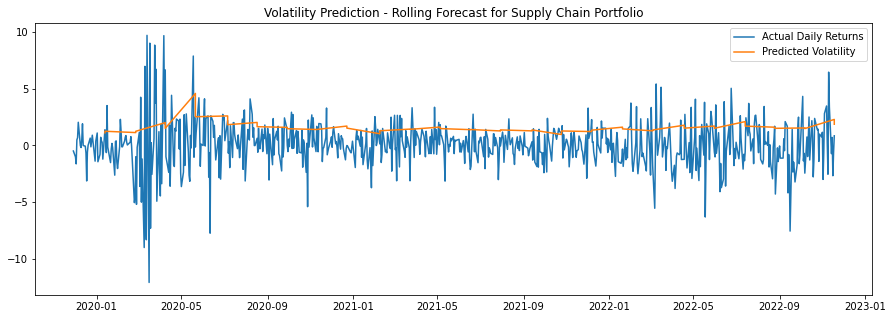

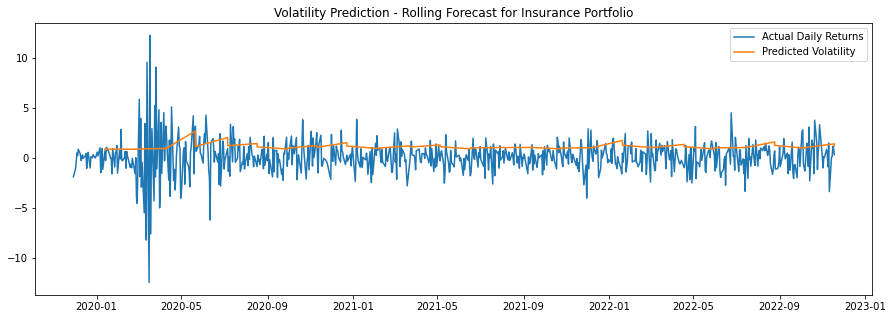

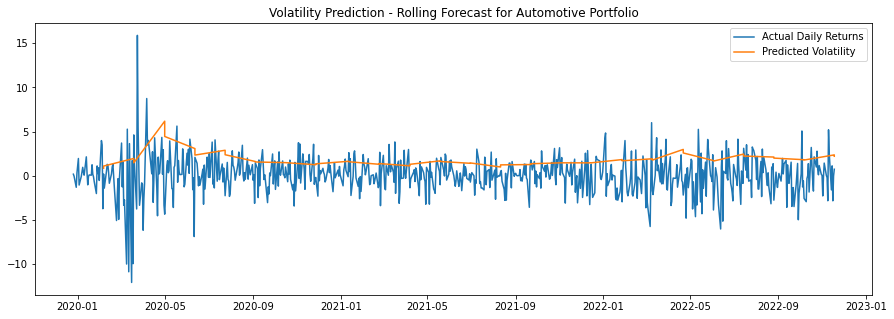

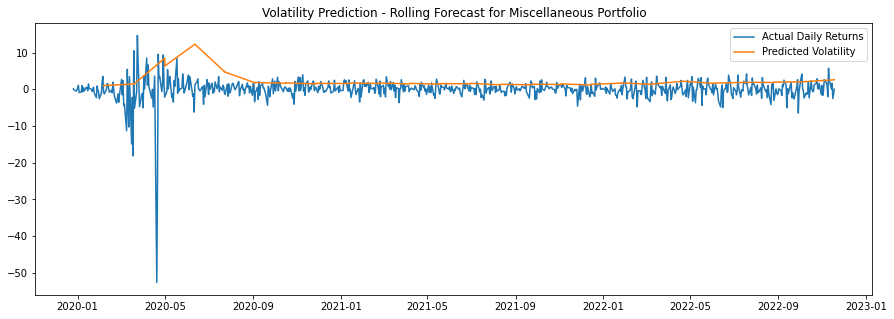

In [17]:
plot_act_pred(returns_supply['avg_return'],sc_30_rolling_predictions,'Volatility Prediction - Rolling Forecast for Supply Chain Portfolio')
plot_act_pred(returns_insurance['avg_return'],i_30_rolling_predictions,'Volatility Prediction - Rolling Forecast for Insurance Portfolio')
plot_act_pred(returns_automotive['avg_return'],a_30_rolling_predictions,'Volatility Prediction - Rolling Forecast for Automotive Portfolio')
plot_act_pred(returns_misc['avg_return'],m_30_rolling_predictions,'Volatility Prediction - Rolling Forecast for Miscellaneous Portfolio')

## Checking accuracy of GARCH Model for 30th day Prediction

In [18]:
tr_days_size = 750
#rolling Prediction of 30 days at a time
horizon_size = 25
sc_30th_rolling_predictions = garch_model(returns_supply['avg_return'],tr_days_size,horizon_size,True)
i_30th_rolling_predictions  = garch_model(returns_insurance['avg_return'],tr_days_size,horizon_size,True)
a_30th_rolling_predictions  = garch_model(returns_automotive['avg_return'],tr_days_size,horizon_size,True)
m_30th_rolling_predictions  = garch_model(returns_misc['avg_return'],tr_days_size,horizon_size,True)

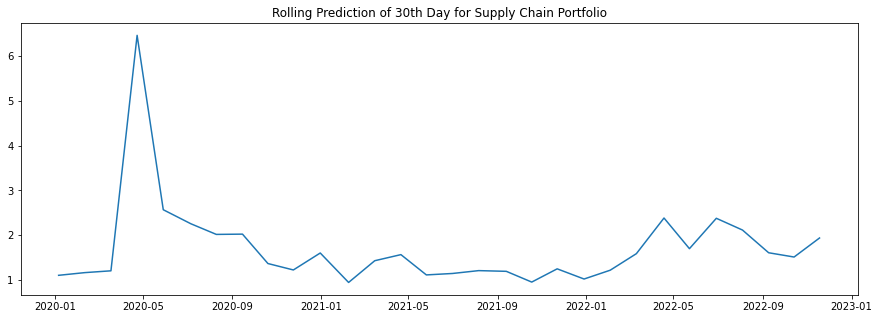

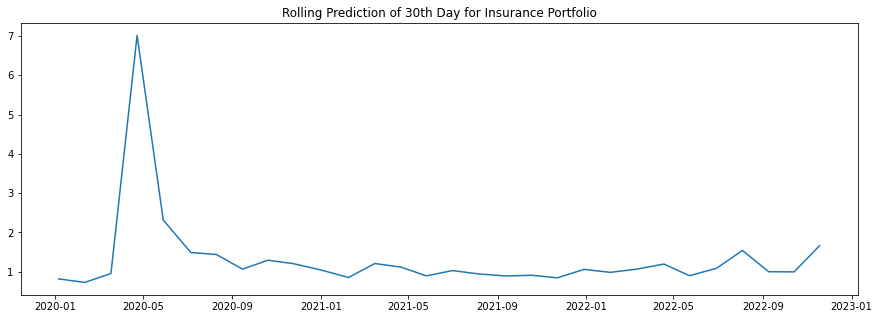

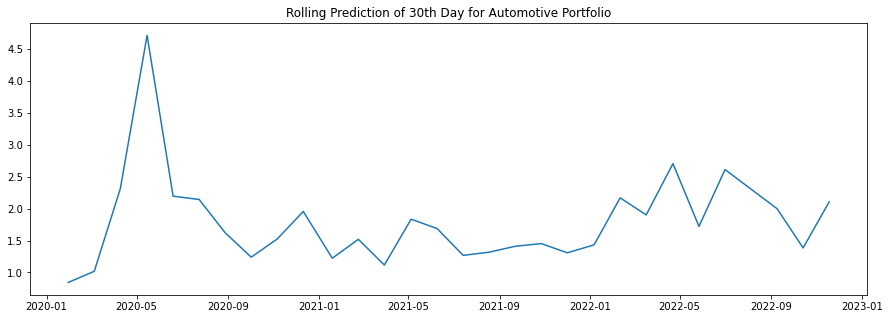

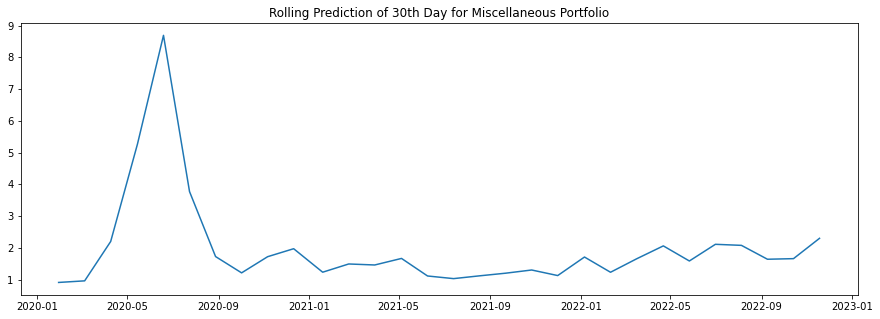

In [19]:
#Plotting the rolling predictions
plot_pred(sc_30th_rolling_predictions,'Rolling Prediction of 30th Day for Supply Chain Portfolio')
plot_pred(i_30th_rolling_predictions,'Rolling Prediction of 30th Day for Insurance Portfolio')
plot_pred(a_30th_rolling_predictions,'Rolling Prediction of 30th Day for Automotive Portfolio')
plot_pred(m_30th_rolling_predictions,'Rolling Prediction of 30th Day for Miscellaneous Portfolio')

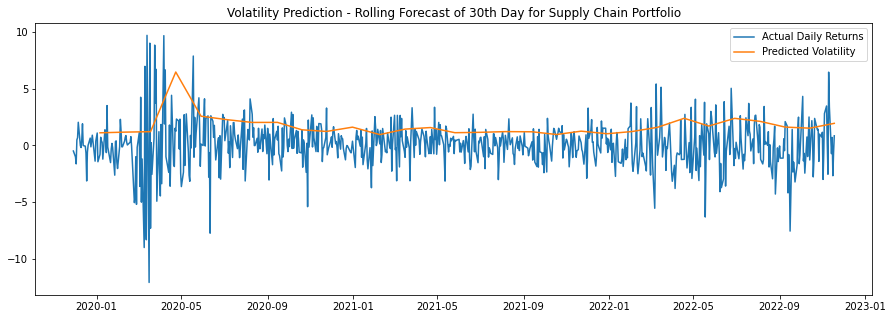

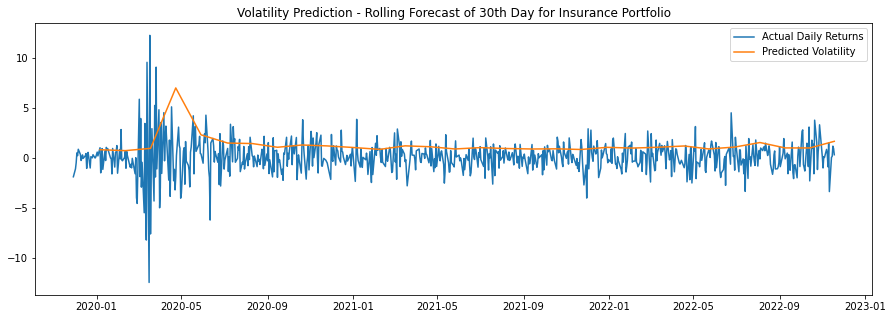

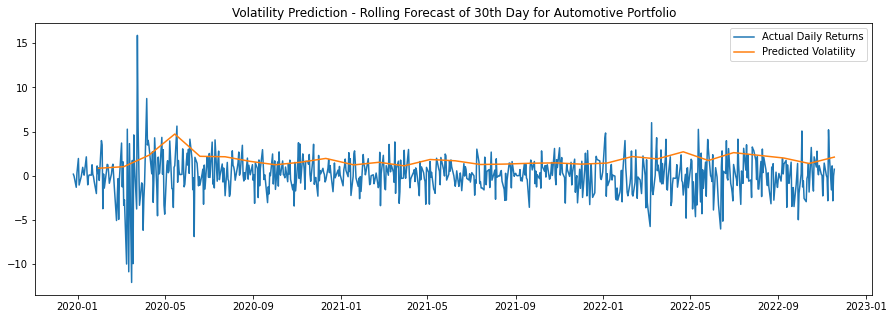

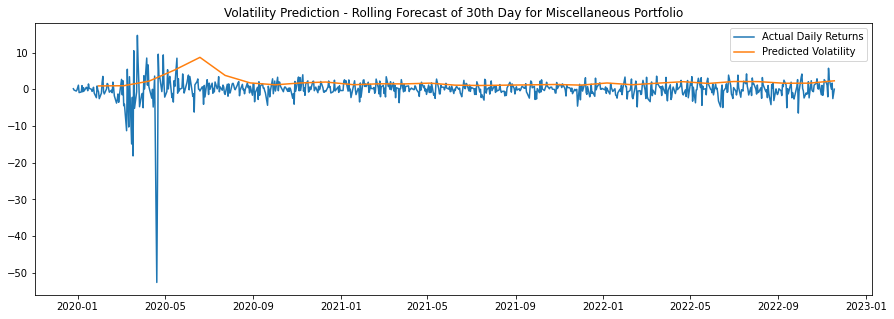

In [20]:
plot_act_pred(returns_supply['avg_return'],sc_30th_rolling_predictions,'Volatility Prediction - Rolling Forecast of 30th Day for Supply Chain Portfolio')
plot_act_pred(returns_insurance['avg_return'],i_30th_rolling_predictions,'Volatility Prediction - Rolling Forecast of 30th Day for Insurance Portfolio')
plot_act_pred(returns_automotive['avg_return'],a_30th_rolling_predictions,'Volatility Prediction - Rolling Forecast of 30th Day for Automotive Portfolio')
plot_act_pred(returns_misc['avg_return'],m_30th_rolling_predictions,'Volatility Prediction - Rolling Forecast of 30th Day for Miscellaneous Portfolio')